In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
import numpy as np
#from colossus.cosmology import cosmology as cc

import matplotlib.pyplot as plt

# Test of pipeline

### Step 1: Setup `Survey` parameters

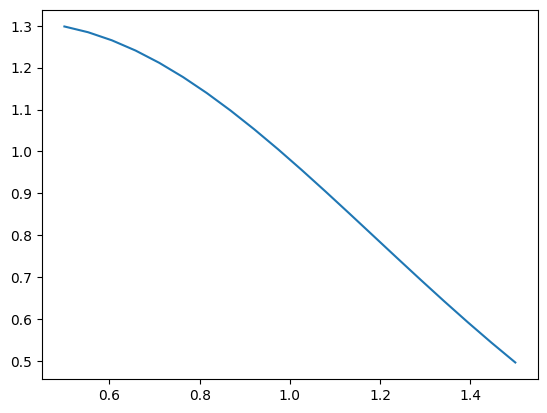

In [52]:
zs = np.linspace(0.5, 1.5, 20)

sigma = 0.79
mu = 0.4
pz = np.sqrt(2/np.pi)/sigma * np.exp(-0.5 * ((zs - mu)/sigma)**2)

# pz renorm such that integral p(z) dz = 1
pz = pz/(pz.sum() * np.diff(zs)[0])

plt.plot(zs, pz)

In [53]:
# Setup Survey

from galCIB import Survey 

LMIN = 100; LMAX=2000
ells = np.arange(LMIN, LMAX)
elg_survey = Survey(zs,pz,2.225,
                    ells, 1024,
                    name='elg')

In [54]:
# Setup Cosmology

ks = np.logspace(-3,1,500)
Mh = np.logspace(7,15,100)

from galCIB import Cosmology

cosmo = Cosmology(elg_survey.z, ks, Mh)

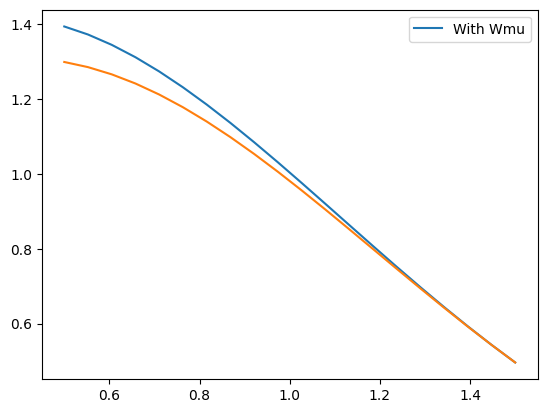

In [55]:
# Calculate window 

elg_survey.compute_windows(cosmo,True)
plt.plot(cosmo.z, elg_survey.Wg, label = 'With Wmu')
plt.plot(zs, pz)
plt.legend(loc='best')

In [78]:
# Setup galaxy HOD

from galCIB import get_hod_model

#register_default_hod_models()
elg_hod_model = get_hod_model("DESI-ELG", cosmo)

In [79]:
# Setup Satellite Profile Model 

from galCIB import SatProfile

theta_sat = np.array([0.58, 6.14, 0.67])
elg_sat_profile = SatProfile(cosmo, theta_sat,
                             profile_type='mixed')

/Users/tkarim/research/galCIB/src/galCIB/satprofile/profile.py:37: UserWarning: For the default mixed profile, theta should be [f_exp, tau_exp, lambda_NFW].
  warnings.warn(


In [80]:
# Setup Power Spectra

In [81]:
theta_cen = np.array([5.47, 11.64, 0.30, 0.1]) # gamma, log10Mc, sigmaM, Ac
theta_sat = np.array([0.41, 10**11.20, 10**13.84, 1]) # As, M0, M1, alpha_sat
#theta_prof = np.array([0.58, 6.14, 0.67]) # fexp, tau, lambda_NFW
theta_prof = np.array([0, 6.14, 1]) # fexp, tau, lambda_NFW

In [82]:
from galCIB import PkBuilder

pow3d = PkBuilder(cosmo,elg_hod_model,elg_sat_profile,
                  theta_cen, theta_sat, theta_prof)

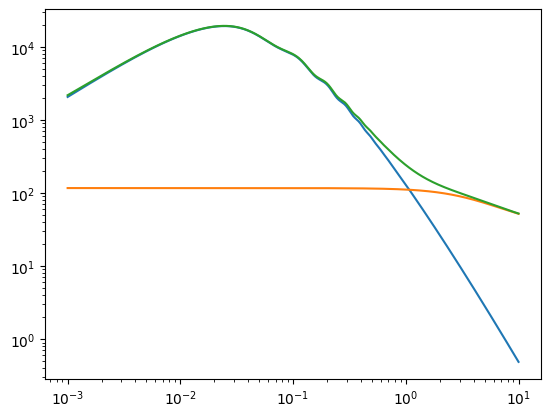

In [83]:
plt.loglog(cosmo.k, pow3d.Pgg_2h[:,1])
plt.loglog(cosmo.k, pow3d.Pgg_1h[:,1])
plt.loglog(cosmo.k, pow3d.Pgg_2h[:,1] + pow3d.Pgg_1h[:,1])

In [84]:
from galCIB import AnalysisModel

In [85]:
elg_cib = AnalysisModel(cosmo,elg_survey,
                        pow3d)

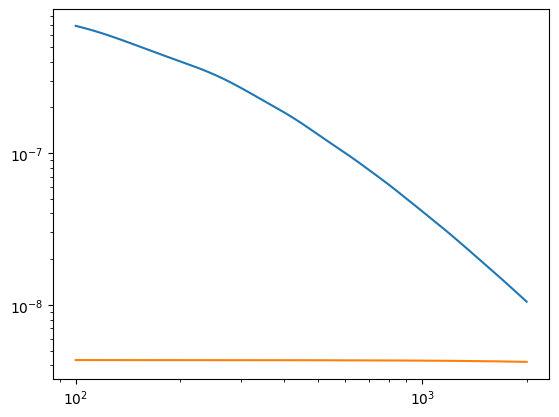

In [86]:
plt.loglog(elg_survey.ells, elg_cib.cl_gg_2h)
plt.loglog(elg_survey.ells, elg_cib.cl_gg_1h)

In [87]:
unwise_cib = AnalysisModel(cosmo,elg_survey,
                        pow3d_unwise)

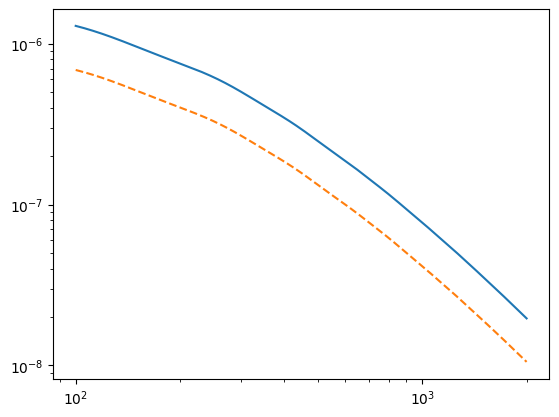

In [89]:
plt.loglog(elg_survey.ells, unwise_cib.cl_gg_2h)
#plt.loglog(elg_survey.ells, unwise_cib.cl_gg_1h)
plt.loglog(elg_survey.ells, elg_cib.cl_gg_2h,ls='--')

In [23]:
%%timeit 

zs = np.linspace(0.5, 1.5, 20)

sigma = 0.79
mu = 0.4
pz = np.sqrt(2/np.pi)/sigma * np.exp(-0.5 * ((zs - mu)/sigma)**2)

# pz renorm such that integral p(z) dz = 1
pz = pz/(pz.sum() * np.diff(zs)[0])

LMIN = 100; LMAX=2000
ells = np.arange(LMIN, LMAX)
elg_survey = Survey(zs,pz,2.225,
                    ells, 1024,
                    name='elg')

ks = np.logspace(-3,1,500)
Mh = np.logspace(7,15,100)

cosmo = Cosmology(elg_survey.z, ks, Mh)

elg_survey.compute_windows(cosmo,True)

elg_hod_model = get_hod_model("DESI-ELG",elg_survey.z)

theta_sat = np.array([0.58, 6.14, 0.67])
elg_sat_profile = SatProfile(cosmo, theta_sat,
                             profile_type='mixed')

theta_cen = np.array([5.47, 11.64, 0.30, 0.1]) # gamma, log10Mc, sigmaM, Ac
theta_sat = np.array([0.41, 10**11.20, 10**13.84, 1]) # As, M0, M1, alpha_sat
theta_prof = np.array([0.58, 6.14, 0.67]) # fexp, tau, lambda_NFW

pow3d = PkBuilder(cosmo,elg_hod_model,elg_sat_profile,
                  theta_cen, theta_sat, theta_prof)

elg_cib = AnalysisModel(cosmo,elg_survey,
                        pow3d)

/Users/tkarim/research/galCIB/src/galCIB/satprofile/profile.py:37: UserWarning: For the default mixed profile, theta should be [f_exp, tau_exp, lambda_NFW].
  warnings.warn(


274 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


About 7 hours for 100,000 calls

In [68]:
zs = np.linspace(0.5, 1.5, 20)

sigma = 0.79
mu = 0.4
pz = np.sqrt(2/np.pi)/sigma * np.exp(-0.5 * ((zs - mu)/sigma)**2)

# pz renorm such that integral p(z) dz = 1
pz = pz/(pz.sum() * np.diff(zs)[0])

LMIN = 100; LMAX=2000
ells = np.arange(LMIN, LMAX)
elg_survey = Survey(zs,pz,2.225,
                    ells, 1024,
                    name='elg')

ks = np.logspace(-3,1,500)
Mh = np.logspace(7,15,100)

cosmo = Cosmology(elg_survey.z, ks, Mh)

elg_survey.compute_windows(cosmo,True)

elg_hod_model = get_hod_model("Zheng05",cosmo)

theta_sat = np.array([10**7, 11.52, -0.02, 1]) #M0, mu0_M1, mup_M1, alpha_sat
elg_sat_profile = SatProfile(cosmo, theta_sat,
                             profile_type='nfw')

theta_cen = np.array([11.26, 2.43, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM
theta_prof = np.array([0, 6.14, 1]) # fexp, tau, lambda_NFW

pow3d_unwise = PkBuilder(cosmo,elg_hod_model,elg_sat_profile,
                  theta_cen, theta_sat, theta_prof)

# elg_cib = AnalysisModel(cosmo,elg_survey,
#                         pow3d)

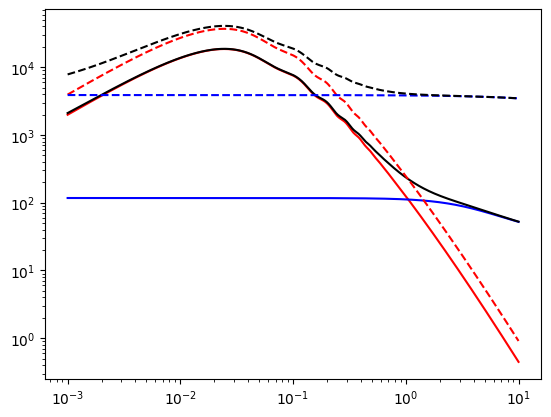

In [73]:
plt.loglog(cosmo.k, pow3d.Pgg_2h[:,1], ls = 'solid',c='r')
plt.loglog(cosmo.k, pow3d.Pgg_1h[:,1], ls = 'solid',c='b')
plt.loglog(cosmo.k, pow3d.Pgg_2h[:,1] + pow3d.Pgg_1h[:,1],
           ls = 'solid', c = 'k')


plt.loglog(cosmo.k, pow3d_unwise.Pgg_2h[:,1], ls ='dashed',c='r')
plt.loglog(cosmo.k, pow3d_unwise.Pgg_1h[:,1], ls ='dashed',c='b')
plt.loglog(cosmo.k, pow3d_unwise.Pgg_2h[:,1] + pow3d_unwise.Pgg_1h[:,1],
           ls ='dashed',c='k')

In [74]:
pow3d_unwise.Pgg_2h[:,1]/pow3d.Pgg_2h[:,1]

array([1.98689077, 1.98689065, 1.98689054, 1.98689042, 1.9868903 ,
       1.98689018, 1.98689006, 1.98688993, 1.98688981, 1.98688967,
       1.98688954, 1.98688941, 1.98688927, 1.98688913, 1.98688899,
       1.98688884, 1.98688869, 1.98688854, 1.98688839, 1.98688823,
       1.98688807, 1.98688791, 1.98688774, 1.98688757, 1.9868874 ,
       1.98688723, 1.98688705, 1.98688687, 1.98688668, 1.98688649,
       1.9868863 , 1.98688611, 1.98688591, 1.9868857 , 1.9868855 ,
       1.98688529, 1.98688507, 1.98688485, 1.98688463, 1.9868844 ,
       1.98688417, 1.98688394, 1.9868837 , 1.98688346, 1.98688321,
       1.98688295, 1.9868827 , 1.98688243, 1.98688217, 1.98688189,
       1.98688162, 1.98688133, 1.98688105, 1.98688075, 1.98688045,
       1.98688015, 1.98687984, 1.98687953, 1.9868792 , 1.98687888,
       1.98687854, 1.9868782 , 1.98687786, 1.98687751, 1.98687715,
       1.98687678, 1.98687641, 1.98687603, 1.98687564, 1.98687525,
       1.98687485, 1.98687444, 1.98687403, 1.9868736 , 1.98687

In [12]:
from galCIB.galaxy.default_models import Ncen_Z05

In [14]:
Ncen_Z05(cosmo.Mh, np.array([11.26, 2.43, 0.4]), z_over_1plusz=elg_hod_model.z_over_1plusz)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [38]:
pow3d.hod.ncen(cosmo.log10Mh_grid,theta_cen)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [13]:
LMIN = 100
LMAX = 2000
ell_range = np.arange(LMIN, LMAX)

def kz_from_ell(ell,cosmo):
    """
    Returns the k(z) grid based on the 
    ell values to be sampled from, as
    a function of z.
    
    Args:
        ell : array of ell values 
        cosmo : Cosmology object to provide chi(z) 
    Returns:
        kz_grid : (Nell, Nz) grid of sampled k values
                    in units of 1/Mpc
    """
    
    kz_grid = (ell[:,np.newaxis] + 0.5)/cosmo.chi[np.newaxis,:]
    
    return kz_grid

In [14]:
kz_grd = kz_from_ell(ell_range,cosmo)

In [15]:
kz_grd.shape

(1900, 20)

In [20]:
kz_grd.min()

0.022447903708366815

In [30]:
tst = np.zeros((len(ell_range), len(zs)))

for zidx in range(len(zs)):
    tst[:,zidx] = np.interp(kz_grd[:,zidx], 
                            ks, pow3d.Pgg_2h[:,zidx])

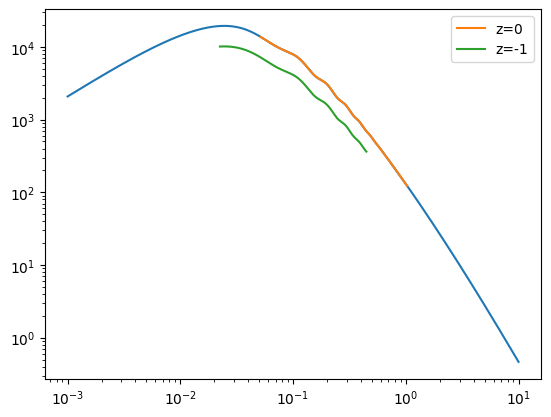

In [34]:
plt.loglog(ks, pow3d.Pgg_2h[:,0])

# for zidx in range(len(zs)):
#     plt.loglog(kz_grd[:,zidx], tst[:,zidx])
zidx=0
plt.loglog(kz_grd[:,zidx], tst[:,zidx],label=f'z={zidx}')

zidx=-1
plt.loglog(kz_grd[:,zidx], tst[:,zidx],label=f'z={zidx}')
plt.legend(loc='best')

In [21]:
pow3d.Pgg_2h.shape

(500, 20)

In [13]:
cosmo.chi

array([1946.38687473, 2120.43020023, 2289.00047704, 2452.255667  ,
       2610.36104322, 2763.48653392, 2911.80446802, 3055.48769257,
       3194.70802633, 3329.63501186, 3460.4349278 , 3587.27002548,
       3710.29795591, 3829.67135683, 3945.53757272, 4058.03848409,
       4167.31042554, 4273.48417509, 4376.68500004, 4477.03274683])

In [13]:
pow3d.Pgg_2h.shape

(500, 20)

In [14]:
from galCIB import AnalysisModel

In [18]:
pow3d.compute_Pgg(hmalpha=1)

In [24]:
mod = AnalysisModel(cosmo, elg_survey, 
                    pow3d, hmalpha=1)

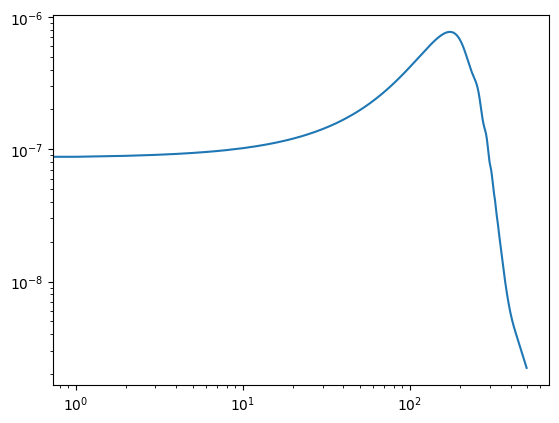

In [25]:
plt.loglog(mod.clgg)

Issues: 
- Calculate $k$ for given $\ell$ per $z$, and re sample $P(k)$. 
- Integrate over the same $\ell$-to-$k$ grid 
- SFR Model test
- SFR Model registry setup
- $S_{\nu}$ Model test 
- $S_{\nu}$ Model registry setup 
- $\theta$ update method in `AnalysisModel`
- Write submodule on MCMC and setup `loglikelihood` method 
- Run MCMC with just $C_{\rm gg}$
- $P_{\rm CIB-CIB}$ and $P_{\rm g-CIB} 
- Refactor `pk.py`; compute.py to contain all the Pk functions? 

In [6]:
from galCIB import get_hod_model


Mh = np.logspace(10, 15, 50)
z = np.ones_like(Mh) * 1.0
theta = [12.0, -0.02, 0.5]  # Example theta_cen

model = get_hod_model("Zheng05",z)
print(model.ncen(Mh, theta))


[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.55111512e-17
 1.05471187e-14 1.48414614e-12 1.35382372e-10 8.01798555e-09
 3.08954852e-07 7.76712747e-06 1.27884798e-04 1.38645357e-03
 9.97488293e-03 4.81831784e-02 1.59098451e-01 3.69337149e-01
 6.29659323e-01 8.40256300e-01 9.51550060e-01 9.89954206e-01
 9.98601426e-01 9.99870783e-01 9.99992139e-01 9.99999687e-01
 9.99999992e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


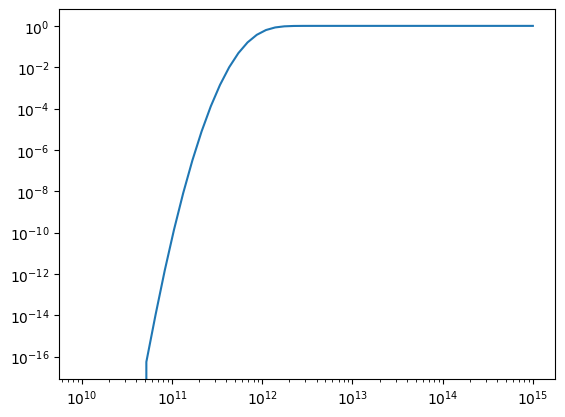

In [7]:
plt.loglog(Mh, model.ncen(Mh, theta))

Test Pk between colossus and camb

In [3]:
from galCIB import Cosmology
from galCIB import Survey
from galCIB import get_hod_model

import numpy as np

In [4]:
zs = np.linspace(0.5, 1.5, 20)

sigma = 0.79
mu = 0.4
pz = np.sqrt(2/np.pi)/sigma * np.exp(-0.5 * ((zs - mu)/sigma)**2)

# pz renorm such that integral p(z) dz = 1
pz = pz/(pz.sum() * np.diff(zs)[0])

ks = np.logspace(-3,1,500)
Mh = np.logspace(7,15,100)

In [6]:
cosmo = Cosmology(zs,ks,Mh,use_little_h=True)

In [8]:
cosmo.cosmo.rho_c(cosmo.z)

array([ 482.70107107,  514.48293742,  548.49492683,  584.81270793,
        623.51195399,  664.66834297,  708.35755748,  754.65528483,
        803.63721696,  855.37905053,  909.95648684,  967.44523185,
       1027.92099623, 1091.45949529, 1158.13644902, 1228.02758208,
       1301.20862381, 1377.75530819, 1457.74337392, 1541.24856433])

In [16]:
from astropy.cosmology import Planck18 as planck
import astropy.units as u
import astropy.cosmology.units as cu

In [26]:
planck.critical_density(cosmo.z).to((u.Msun)/u.Mpc**3)# /cosmo.cosmo.h**2

<Quantity [2.20960565e+11, 2.35507559e+11, 2.51075269e+11, 2.67698324e+11,
           2.85411353e+11, 3.04248991e+11, 3.24245871e+11, 3.45436629e+11,
           3.67855905e+11, 3.91538337e+11, 4.16518569e+11, 4.42831243e+11,
           4.70511006e+11, 4.99592505e+11, 5.30110389e+11, 5.62099311e+11,
           5.95593922e+11, 6.30628878e+11, 6.67238836e+11, 7.05458455e+11] solMass / Mpc3>

In [29]:
cu.with_H0(cosmo.H0*u.km/u.s/u.Mpc)

Equivalency([(Unit("1.47798 littleh"), None)])

In [31]:
tst = cosmo.cosmo.rho_c(cosmo.z) * (u.Msun * cu.littleh**2/u.kpc**3)
tst

<Quantity [ 482.70107107,  514.48293742,  548.49492683,  584.81270793,
            623.51195399,  664.66834297,  708.35755748,  754.65528483,
            803.63721696,  855.37905053,  909.95648684,  967.44523185,
           1027.92099623, 1091.45949529, 1158.13644902, 1228.02758208,
           1301.20862381, 1377.75530819, 1457.74337392, 1541.24856433] littleh2 solMass / kpc3>

In [34]:
tst.to(u.Msun/u.Mpc**3, 
       cu.with_H0(cosmo.H0*u.km/u.s/u.Mpc)).value

array([2.20974546e+11, 2.35523889e+11, 2.51094154e+11, 2.67719983e+11,
       2.85436016e+11, 3.04276899e+11, 3.24277278e+11, 3.45471801e+11,
       3.67895121e+11, 3.91581888e+11, 4.16566760e+11, 4.42884392e+11,
       4.70569445e+11, 4.99656579e+11, 5.30180459e+11, 5.62175750e+11,
       5.95677121e+11, 6.30719241e+11, 6.67336782e+11, 7.05564420e+11])

In [37]:
from colossus.cosmology import cosmology
cosmoc = cosmology.setCosmology('planck18')

In [43]:
tst1 = cosmoc.matterPowerSpectrum(cosmo.k,cosmo.z[0],
                          model = 'camb',
                          derivative = True)

tst2 = cosmoc.matterPowerSpectrum(cosmo.k,cosmo.z[10],
                          model = 'camb',
                          derivative = True)

tst3 = cosmoc.matterPowerSpectrum(cosmo.k,cosmo.z[5],
                          model = 'camb',
                          derivative = True)

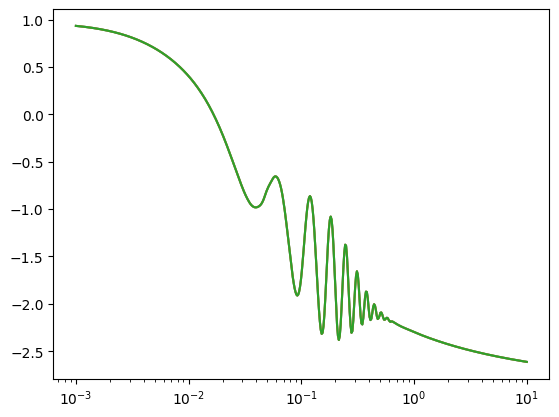

In [46]:
plt.semilogx(cosmo.k, tst1)
plt.semilogx(cosmo.k, tst2)
plt.semilogx(cosmo.k, tst3)

In [ ]:
grad = np.zeros(self.power.shape, float)
grad[0:-1] = np.diff(np.log(self.power)) / np.diff(np.log(self.kk))
grad[-1] = (np.log(self.power[-1]) - np.log(self.power[-2]))/(np.log(self.kk[-1]) - np.log(self.kk[-2]))
# grad_smoothed = savgol_filter(grad, 51, 2)
grad_smoothed = grad

In [51]:
.shape

(500,)

In [53]:
tmp = np.diff(np.log(cosmo.get_pk_grid()[:,0]))/np.diff(np.log(cosmo.k))

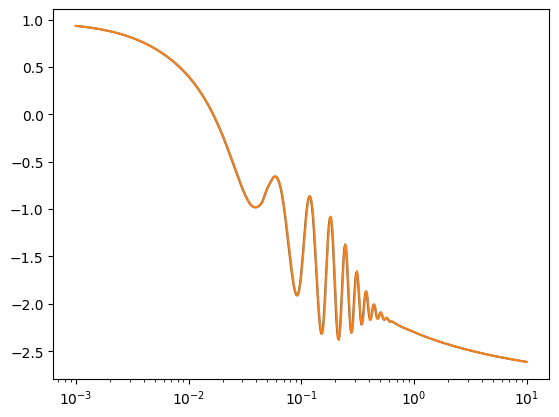

In [55]:
plt.semilogx(cosmo.k[:-1], tmp)
plt.semilogx(cosmo.k, tst1)

In [56]:
from colossus.halo import concentration 

In [57]:
for model_name in concentration.models:
    print(model_name)

bullock01
duffy08
klypin11
prada12
bhattacharya13
dutton14
diemer15_orig
diemer15
klypin16_m
klypin16_nu
ludlow16
child18
diemer19
ishiyama21


In [63]:
Mh_in_units = (cosmo.Mh * u.Msun)
Mh_in_units

<Quantity [1.00000000e+07, 1.20450354e+07, 1.45082878e+07, 1.74752840e+07,
           2.10490414e+07, 2.53536449e+07, 3.05385551e+07, 3.67837977e+07,
           4.43062146e+07, 5.33669923e+07, 6.42807312e+07, 7.74263683e+07,
           9.32603347e+07, 1.12332403e+08, 1.35304777e+08, 1.62975083e+08,
           1.96304065e+08, 2.36448941e+08, 2.84803587e+08, 3.43046929e+08,
           4.13201240e+08, 4.97702356e+08, 5.99484250e+08, 7.22080902e+08,
           8.69749003e+08, 1.04761575e+09, 1.26185688e+09, 1.51991108e+09,
           1.83073828e+09, 2.20513074e+09, 2.65608778e+09, 3.19926714e+09,
           3.85352859e+09, 4.64158883e+09, 5.59081018e+09, 6.73415066e+09,
           8.11130831e+09, 9.77009957e+09, 1.17681195e+10, 1.41747416e+10,
           1.70735265e+10, 2.05651231e+10, 2.47707636e+10, 2.98364724e+10,
           3.59381366e+10, 4.32876128e+10, 5.21400829e+10, 6.28029144e+10,
           7.56463328e+10, 9.11162756e+10, 1.09749877e+11, 1.32194115e+11,
           1.59228279e+11

In [66]:
Mh_in_littleh = Mh_in_units.to(u.Msun/cu.littleh,
               cu.with_H0(cosmo.H0*u.km/u.s/u.Mpc))

In [47]:
DESI = Survey(zs, pz, 1.5, "DESI")

In [58]:
DESI.compute_windows(cosmo)

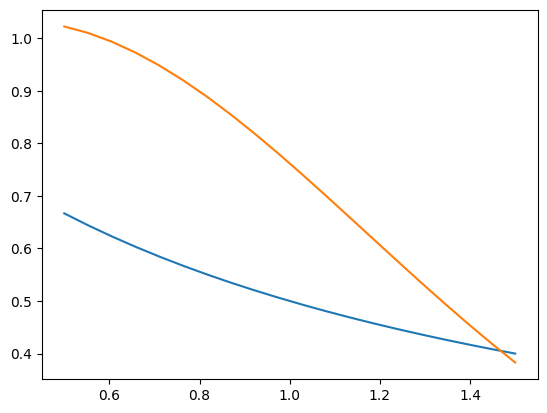

In [61]:
plt.plot(DESI.z, DESI.Wg)
plt.plot(DESI.z, DESI.Wcib)

In [18]:
tst.get_pk_grid().shape

(500, 20)

In [43]:
tst.cosmo.comovingDistance(0,0.5, transverse=True)/tst.cosmo.h

1946.386874732119

In [44]:
from astropy.cosmology import Planck18 as planck

In [45]:
planck.comoving_distance(0.5)

<Quantity 1946.41663479 Mpc>

In [49]:
tst.cosmo.H0

67.66

In [48]:
planck.H(zs)

<Quantity [ 89.22719344,  92.11752752,  95.11342383,  98.21157428,
           101.40875928, 104.70186558, 108.08789867, 111.56399062,
           115.12740422, 118.77553438, 122.50590717, 126.31617726,
           130.20412409, 134.16764725, 138.20476119, 142.31358965,
           146.49235995, 150.73939714, 155.05311836, 159.43202724] km / (Mpc s)>

In [50]:
tst.cosmo.Om0

0.3111

- 1: Specify cosmology
- 2: Specify survey